In [27]:
import os
import nibabel as nib
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pickle
from reeb_grapher import *

from mpl_toolkits.mplot3d import Axes3D


In [29]:
# Load the pickle file
reebgraph_dir = "/Users/mansoor/Documents/Projects/DTI-Analysis/dti-scripts/ReebGraph/"

trkfolderO = reebgraph_dir + 'output/'
pickle_file = 'sub-201208231812457_dwi.src.gz.odf.hcp1065.qsdr.1.25.R77.trk.gz.pickle'
pickle_path = os.path.join(trkfolderO, pickle_file)

# Load the corresponding .trk file
trkfolderI = reebgraph_dir + 'Data/'
trk_file = 'sub-201208231812457_dwi.src.gz.odf.hcp1065.qsdr.1.25.R77.trk.gz'
trk_path = os.path.join(trkfolderI, trk_file)

with open(pickle_path, 'rb') as handle:
    dic_T = pickle.load(handle)

trk = nib.streamlines.load(trk_path)
streamlines = trk.streamlines
num_trajectories = len(streamlines)
print(f"Number of trajectories: {num_trajectories}")
print(f"First trajectory shape: {streamlines[0].shape}")
# print(f"First trajectory points: {streamlines[0]}")

Number of trajectories: 1699
First trajectory shape: (121, 3)


/var/folders/kj/vbx4s2zd1v1ff2bc0p2tvy6r0000gn/T/ipykernel_67504/3972655438.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap('coolwarm')


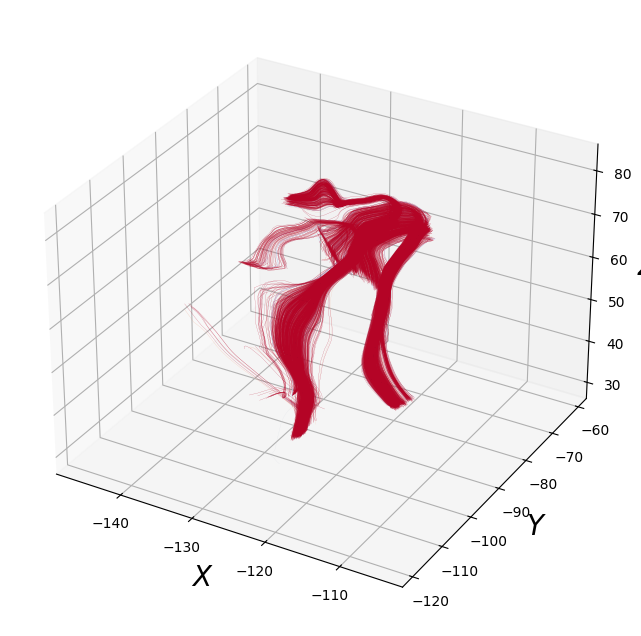

In [25]:
plt.figure(figsize = (20,8))
ax = plt.axes(projection='3d')
cmap = matplotlib.cm.get_cmap('coolwarm')
color = np.array([cmap(i) for i in range(len(streamlines))] )
# color=['#004D40', '#1E88E5', '#FFC107']
for i in range(len(streamlines)):
    xdata = []
    ydata = []
    zdata = []
    for j in streamlines[i]:
        xdata.append(j[0])
        ydata.append(j[1]) 
        zdata.append(j[2])
# ax.plot3D(trk.streamlines[0], trk.streamlines[6], trk.streamlines[7], color=['r','k','b']);
    ax.plot3D(xdata,ydata,zdata,color=color[i], label = "Trajectory"+str(i+1), lw = 0.1);
# ax.plot3D(xdata[10:20],ydata[10:20],zdata[10:20],color='g');
ax.set_xlabel('$X$', fontsize = 20)
ax.set_ylabel('$Y$', fontsize = 20)
ax.set_zlabel('$Z$', fontsize = 20)
plt.show()

In [ ]:
# Create the image
eps = 4
I = create_image(streamlines, eps)

# Construct the Reeb graph
R = nx.Graph()
check_traj = np.zeros((len(I.trajectories), 2000), dtype=bool) # Flag considered points of the trajectories; we are assuming if each trajectory has a maximum of 2000 points
tree_node_map = {} # for final merge
node_coordinate_map = {} # for location of nodes
nc = 0 # node count

for s in range(len(I.trajectories)): # start with trajectories in I one by one
    # print("Processing trajectory", s) 
    M = {}
    prev_connected_comp = []
    T1 = I.trajectories[s]
    trajectory_to_node_map_pres = {}
    trajectory_to_node_map_prev = {}

    if not (check_traj[s][0]): # check first point of the trajectory (if first is already considered then all following points are already considered)
        G = nx.Graph() # This graph will be modified dynamically
        traj_list = [s] # all trajectories to be taken into account in this batch
        ind_list = [0] # corresponding indices of above
        while (len(traj_list) > 0): # go on till the trajectories to be considered have not exhausted
            del_ind_tra = []
            disconnected_events = []
            disappear_events = []
            eventFlag = False
            i = 0
            delete_nodes = []
            while (i < len(traj_list)):
                if not (check_traj[traj_list[i]][ind_list[i]]):
                    check_traj[traj_list[i]][ind_list[i]] = True
                    if dic_T[traj_list[i]].get(ind_list[i]):
                        events = dic_T[traj_list[i]][ind_list[i]]
                        for e in events:
                            if not e.considered:
                                eventFlag = True
                                if e.event == "appear":
                                    G.add_node(traj_list[i])
                                    e.considered = True
                                elif e.event == "connect":
                                    G.add_node(e.trajectory2)
                                    G.add_node(e.trajectory1)
                                    G.add_edge(e.trajectory1, e.trajectory2)
                                    if e.trajectory2 not in traj_list:
                                        traj_list.append(e.trajectory2)
                                        ind_list.append(e.t2)
                                        connect_j = []
                                        temp_dic = {}
                                        for j in range(e.t2): # to handle events before non zero index
                                            if dic_T[e.trajectory2].get(j):
                                                eventj = dic_T[e.trajectory2][j] # event at index j
                                                for ej in eventj:
                                                    if ej.event == "connect":
                                                        if ej.trajectory2 != e.trajectory2:
                                                            connect_j.append(ej.trajectory2)
                                                            temp_dic[ej.trajectory2] = [j, ej.t2]
                                                        else:
                                                            connect_j.append(ej.trajectory1)
                                                            temp_dic[ej.trajectory1] = [j, ej.t1]
                                                    elif ej.event == "disconnect":
                                                        if ej.trajectory2 in connect_j:
                                                            connect_j.remove(ej.trajectory2)
                                                        elif ej.trajectory1 in connect_j:
                                                            connect_j.remove(ej.trajectory1)
                                        for c in connect_j:
                                            G.add_node(c)
                                            G.add_edge(e.trajectory2, c)
                                            if c not in traj_list:
                                                traj_list.append(c)
                                                ind_list.append(temp_dic[c][1] - temp_dic[c][0] + e.t2)
                                    if e.trajectory1 not in traj_list:
                                        traj_list.append(e.trajectory1)
                                        ind_list.append(e.t1)
                                        connect_j = []
                                        temp_dic = {}
                                        for j in range(e.t1): # to handle events before non zero index
                                            if dic_T[e.trajectory1].get(j):
                                                eventj = dic_T[e.trajectory1][j] # event at index j
                                                for ej in eventj:
                                                    if ej.event == "connect":
                                                        if ej.trajectory1 != e.trajectory1:
                                                            connect_j.append(ej.trajectory1)
                                                            temp_dic[ej.trajectory1] = [j, ej.t1]
                                                        else:
                                                            connect_j.append(ej.trajectory2)
                                                            temp_dic[ej.trajectory2] = [j, ej.t2]
                                                    elif ej.event == "disconnect":
                                                        if ej.trajectory1 in connect_j:
                                                            connect_j.remove(ej.trajectory1)
                                                        elif ej.trajectory2 in connect_j:
                                                            connect_j.remove(ej.trajectory2)
                                        for c in connect_j:
                                            G.add_node(c)
                                            G.add_edge(e.trajectory1, c)
                                            if c not in traj_list:
                                                traj_list.append(c)
                                                ind_list.append(temp_dic[c][1] - temp_dic[c][0] + e.t1)
                                    e.considered = True
                                elif e.event == "disconnect":
                                    if G.has_node(e.trajectory2) and G.has_node(e.trajectory1):
                                        disconnected_events.append(e)
                                        if G.has_edge(e.trajectory1, e.trajectory2):
                                            G.remove_edge(e.trajectory1, e.trajectory2)
                                            e.considered = True
                                    else:
                                        check_traj[traj_list[i]][ind_list[i]] = False
                                elif e.event == "disappear":
                                    disappear_events.append(e)
                                    delete_nodes.append(traj_list[i])
                                    del_ind_tra.append(i)
                                    e.considered = True
                else:
                    delete_nodes.append(traj_list[i])
                    del_ind_tra.append(i)
                    if trajectory_to_node_map_prev.get(traj_list[i]):
                        R.add_edge(M[trajectory_to_node_map_prev[traj_list[i]]], tree_node_map[traj_list[i]])
                    i = len(traj_list)
                i += 1
            if eventFlag:
                if len(prev_connected_comp) == 0: # this will be executed only once
                    prev_connected_comp = [c for c in nx.connected_components(G)]
                    for prev_cc in prev_connected_comp:
                        R.add_node(nc)
                        M[frozenset(prev_cc)] = nc
                        for ci in prev_cc:
                            trajectory_to_node_map_prev[ci] = frozenset(prev_cc)
                            if not tree_node_map.get(ci):
                                tree_node_map[ci] = nc
                        nc += 1
                else:
                    pres_connected_component = [c for c in nx.connected_components(G)]
                    for pres_cc in pres_connected_component:
                        for ci in pres_cc:
                            trajectory_to_node_map_pres[ci] = frozenset(pres_cc)
                            for c_individual in pres_cc:
                                if not tree_node_map.get(c_individual):
                                    tree_node_map[c_individual] = nc
                    copied_nodes = [] # this will store all split events
                    if len(disconnected_events) != 0:
                        for de in disconnected_events:
                            C1 = None
                            C2 = None
                            if trajectory_to_node_map_prev.get(de.trajectory1):
                                C1 = trajectory_to_node_map_prev[de.trajectory1]
                            else:
                                check_traj[de.trajectory1][de.t1] = False
                            if trajectory_to_node_map_prev.get(de.trajectory2):
                                C2 = trajectory_to_node_map_prev[de.trajectory2]
                            else:
                                check_traj[de.trajectory2][de.t2] = False
                            if C1 == None and C2 == None:
                                continue
                            elif C1 != C2:
                                continue
                            elif C1 not in copied_nodes and (trajectory_to_node_map_pres[de.trajectory1] != trajectory_to_node_map_prev[de.trajectory1]):
                                R.add_node(nc)
                                R.add_edge(M[C1], nc)
                                copied_nodes.append(C1)
                                M[frozenset(C1)] = nc
                                nc += 1
                    for cc in pres_connected_component:
                        if cc in prev_connected_comp: # do nothing: still epsilon connected
                            continue
                        else:
                            check = False
                            check_cc = False
                            for cn in copied_nodes:
                                if cc.issubset(cn):
                                    M[frozenset(cc)] = M[frozenset(cn)]
                                    check_cc = True
                            if not check_cc:
                                for prev_cc in prev_connected_comp:
                                    # add edge if nodes are neighbor
                                    if prev_cc.intersection(cc):
                                        check = True
                                        R.add_node(nc)
                                        M[frozenset(cc)] = nc
                                        R.add_edge(M[frozenset(prev_cc)], M[frozenset(cc)])
                                        for c_individual in cc:
                                            if not tree_node_map.get(c_individual):
                                                tree_node_map[c_individual] = nc
                                        nc += 1
                            if not check:
                                R.add_node(nc)
                                M[frozenset(cc)] = nc
                                for c_individual in cc:
                                    if not tree_node_map.get(c_individual):
                                        tree_node_map[c_individual] = nc
                                nc += 1
                    if len(disappear_events) != 0:
                        for da in disappear_events:
                            C1 = None
                            if trajectory_to_node_map_prev.get(da.trajectory1):
                                C1 = trajectory_to_node_map_prev[da.trajectory1]
                                check = False
                                if len(C1) == 1:
                                    for x in range(len(I.trajectories[list(C1)[0]].points)):
                                        if dic_T[list(C1)[0]].get(x) and "connect" in [y.event for y in dic_T[list(C1)[0]][x]]:
                                            check = True
                                            continue
                                    if check and C1 in prev_connected_comp:
                                        pc = M[frozenset(C1)]
                                    else:
                                        R.add_node(nc)
                                        R.add_edge(M[C1], nc)
                                        M[frozenset(C1)] = nc
                                        nc += 1
                    prev_connected_comp = []
                    for cx in pres_connected_component:
                        prev_connected_comp.append(cx)
                    trajectory_to_node_map_prev = trajectory_to_node_map_pres
                    trajectory_to_node_map_pres = {}
                for node in delete_nodes:
                    if G.has_node(node):
                        G.remove_node(node)
            ind_list = [x + 1 for x in ind_list]
            for j in range(len(traj_list)):
                if ind_list[j] >= len(I.trajectories[traj_list[j]].points):
                    del_ind_tra.append(j)
            traj_list = [i for j, i in enumerate(traj_list) if j not in del_ind_tra]
            ind_list = [i for j, i in enumerate(ind_list) if j not in del_ind_tra]



In [30]:
print(f"num of nodes: {len(R.nodes())}, num of edges: {len(R.edges())}")

num of nodes: 3106, num of edges: 1884


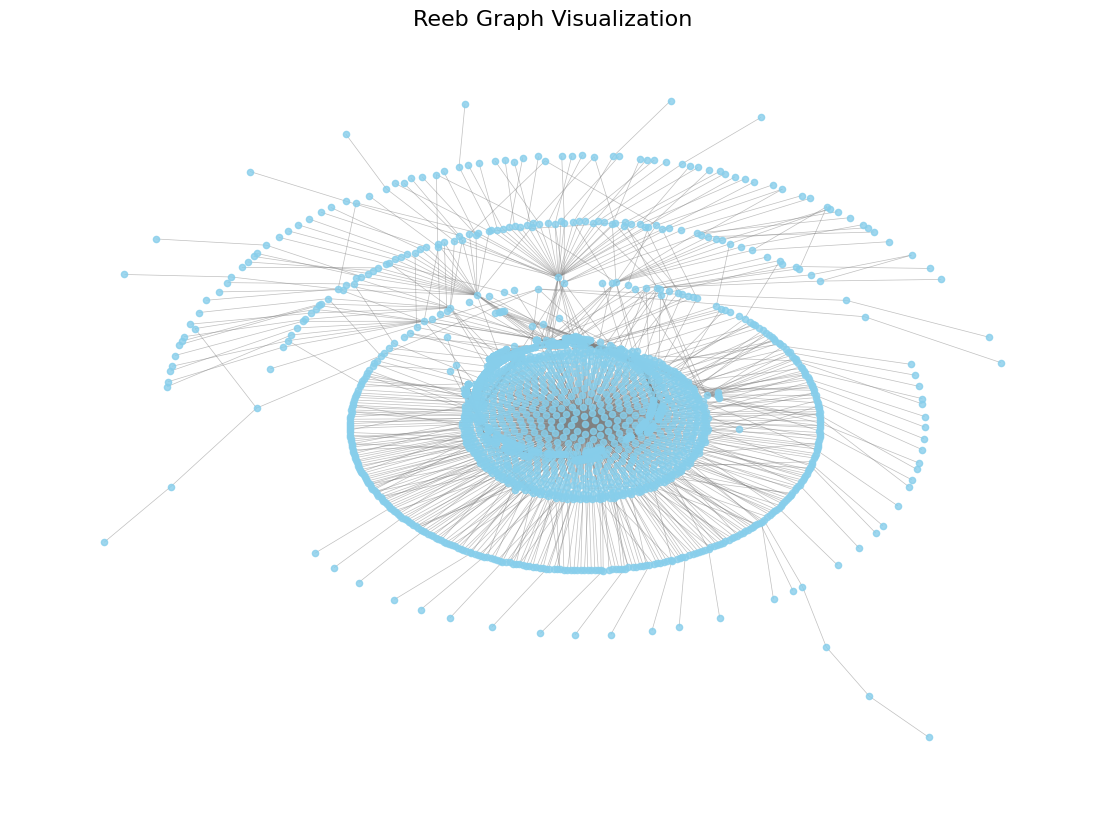

In [15]:
# Visualize the Reeb graph
pos = nx.kamada_kawai_layout(R)  # Kamada-Kawai layout for better node spacing

# Draw nodes and edges
plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(R, pos, node_size=20, node_color='skyblue', alpha=0.8)
nx.draw_networkx_edges(R, pos, width=0.5, alpha=0.5, edge_color='gray')

# Customize the plot
plt.title("Reeb Graph Visualization", fontsize=16)
plt.axis('off')
plt.show()


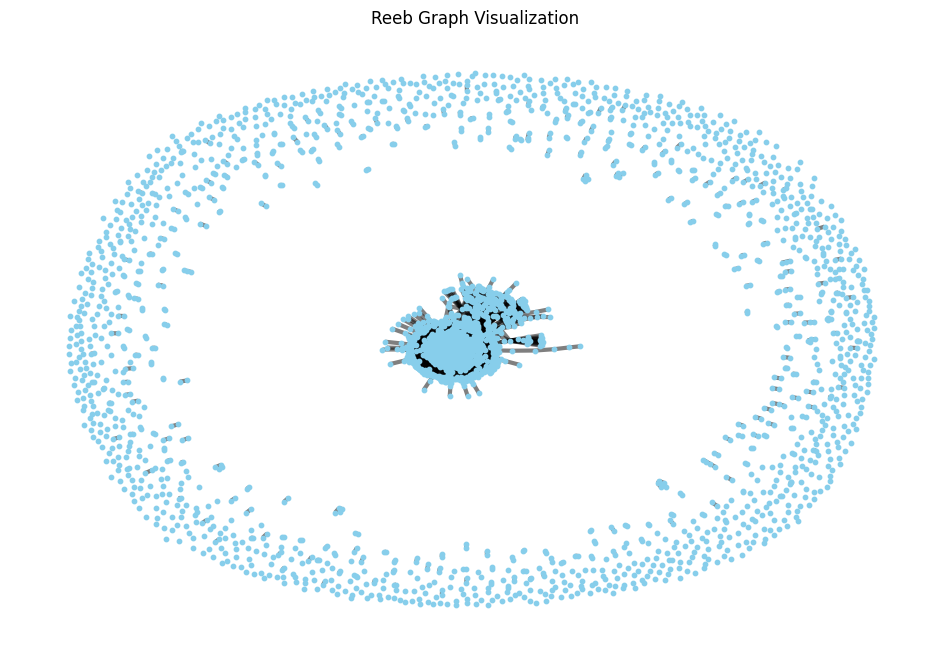

In [32]:
# Visualize the Reeb graph
pos = nx.spring_layout(R, seed=42)  # positions for all nodes

# Draw nodes and edges
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(R, pos, node_size=10, node_color='skyblue', alpha=1)
nx.draw_networkx_edges(R, pos, width=3.0, alpha=0.5)
# nx.draw_networkx_labels(R, pos, font_size=10, font_family='sans-serif')

# Customize the plot
plt.title("Reeb Graph Visualization")
plt.axis('off')
plt.show()


## original test code

In [2]:
# In[2]:

streamlines = [[[-2,21,0],[0,20,0], [2,19.5,0], [3,19,0], [4.5,18,0], [5,17,0], [5.5,16,0], [6,15,0], [6,14,0], [5.5,12,0], [5.5,11,0], [5.25,10,0], [5,9,0], [4,8,0], [3.5,7,0], [1.5,5,0]],
               [[-1,21,0],[0.5,20,0],[2,19,0],[2.5,18.5,0],[3.5,18,0],[4,17.5,0],[5.5,17,0],[5.5,16,0],[5.75,15,0],[5.5,14,0],[6,13,0],[6,12,0],[6,11,0],[5.5,10,0],[5,8,0],[4.5,7.5,0],[4,7,0],[3,6,0],[2,4,0]],
               [[-1,19.5,0],[0,19,0],[1,19,0],[2.5,18,0],[3,17.75,0],[4,17.5,0],[5,17,0],[6,16,0],[6.5,15.5,0],[6.5,14,0],[6,13.5,0],[5.5,13,0],[5.5,12,0],[5,10,0],[4.5,9,0],[4,8,0],[3,6,0],[2.5,5,0]],
               [[12,22,0],[11,21,0],[10,20,0],[9,18.5,0],[8,17.5,0],[7,16.5,0],[6,14.5,0],[6,14,0],[5.5,13.5,0],[6,12.5,0],[5.75,12,0],[5.75,11,0],[6,10,0],[6.5,9,0],[7,8,0],[8,7,0],[8.5,6,0],[9,5,0],[10,4,0]],
               [[12,21,0],[11,20,0],[10,19,0],[9,18,0],[8,17,0],[7,16,0],[7,15,0],[6.5,14,0],[6.5,13,0],[6.5,12,0],[7,11,0],[7,10,0],[7.5,9,0],[8,8,0],[9,7,0],[10,6,0],[11,5,0]],
               [[12,20.5,0],[11,19.5,0],[10,18.5,0],[9,17,0],[8,16,0],[7,15,0],[7,14,0],[7,13,0],[7,11,0],[7.5,10,0],[8,9,0],[9,8,0],[10,7,0],[11,6,0],[12,5,0],[13,4,0]]
              ]

/var/folders/kj/vbx4s2zd1v1ff2bc0p2tvy6r0000gn/T/ipykernel_67504/1379349798.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap('coolwarm')


Text(0.5, 0, '$Z$')

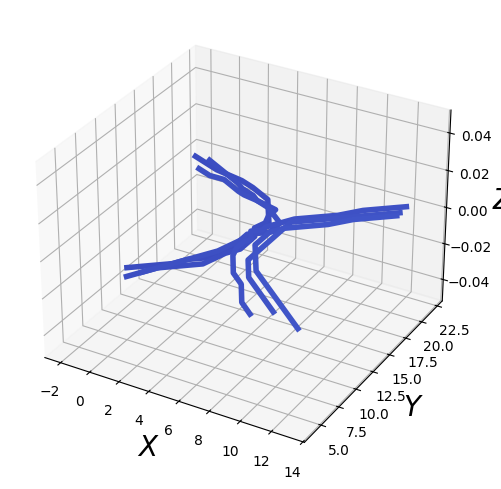

In [3]:
plt.figure(figsize = (8,6))
ax = plt.axes(projection='3d')
cmap = matplotlib.cm.get_cmap('coolwarm')
color = np.array([cmap(i) for i in range(len(streamlines))] )
# color=['#004D40', '#1E88E5', '#FFC107']
for i in range(len(streamlines)):
    xdata = []
    ydata = []
    zdata = []
    for j in streamlines[i]:
        xdata.append(j[0])
        ydata.append(j[1])
        zdata.append(j[2])
# ax.plot3D(trk.streamlines[0], trk.streamlines[6], trk.streamlines[7], color=['r','k','b']);
    ax.plot3D(xdata,ydata,zdata,color=color[i], label = "Trajectory"+str(i+1), lw = 4);
# ax.plot3D(xdata[10:20],ydata[10:20],zdata[10:20],color='g');
ax.set_xlabel('$X$', fontsize = 20)
ax.set_ylabel('$Y$', fontsize = 20)
ax.set_zlabel('$Z$', fontsize = 20)

In [ ]:
# In[4]:

print(len(streamlines))

6


In [ ]:
# In[5]:

eps = 4
from reeb_grapher import *
I = create_image(streamlines, eps)
dic_T = create_trajectory_dic(I, eps)

0 1
0 2
0 3
0 4
0 5
1 2
1 3
1 4
1 5
2 3
2 4
2 5
3 4
3 5
4 5


In [ ]:
# In[6]:

max_traj_len = 0
for traj_i in range((len(I.trajectories))):
    max_traj_len = max(max_traj_len,len(I.trajectories[traj_i].points))
print(max_traj_len) 

19


In [ ]:
# In[6]:

max_traj_len = 0
for traj_i in range((len(I.trajectories))):
    max_traj_len = max(max_traj_len,len(I.trajectories[traj_i].points))
print(max_traj_len) 

19


In [ ]:
# In[7]:

R = nx.Graph()
check_traj = np.zeros((len(I.trajectories), max_traj_len), dtype=bool) #Flag considered points of the trajectories; we are assuming if each trajetcory has a maximum of 2000 points
tree_node_map = {} #for final merge
node_coordinate_map = {} #for location of nodes
nc = 0 #node count

In [ ]:
M = {}
for s in range(len(I.trajectories)): #start with trajectories in I one by one
    print("Processing trajectory", s)
    prev_connected_comp = []
    T1 = I.trajectories[s]
    trajectory_to_node_map_pres = {}
    trajectory_to_node_map_prev = {}
    
    if not (check_traj[s][0]): #check first point of the trajectory (if first is already considered then all following points are already considered)
        G = nx.Graph() # This graph will be modified dynamically
        traj_list = [s] # all trajectories to be taken into acount in this batch
        ind_list = [0] #corresponding indices of above
        while (len(traj_list)>0): #go on till the trajectories to be considered have not exhausted
            del_ind_tra = []
            delete_nodes = []
            disconnected_events = []
            disappear_events = []
            eventFlag = False
            i = 0
            while (i < len(traj_list)):
                if not (check_traj[traj_list[i]][ind_list[i]]):                   
                    check_traj[traj_list[i]][ind_list[i]] = True
                    if dic_T[traj_list[i]].get(ind_list[i]):
                        events = dic_T[traj_list[i]][ind_list[i]]                        
                        for e in events:
                            if not e.considered:                            
                                eventFlag = True
                                if e.event == "appear":
#                                     print("Appear ", e.trajectory1)
                                    G.add_node(traj_list[i])                                     
                                    e.considered = True

                                elif e.event == "connect":
#                                     print("Connected event between", e.trajectory1, e.trajectory2)
                                    G.add_node(e.trajectory2)
                                    G.add_node(e.trajectory1)
                                    G.add_edge( e.trajectory1, e.trajectory2)
                                    # events of interests
                                    if e.trajectory2 not in traj_list:
                                        traj_list.append(e.trajectory2)
                                        ind_list.append(e.t2)
                                        connect_j = []
                                        temp_dic = {}
                                        for j in range(e.t2): # to handle events before non zero index
                                            if  dic_T[e.trajectory2].get(j):
                                                eventj = dic_T[e.trajectory2][j]   #event at index j                                      
                                                for ej in eventj:
                                                    if(ej.event == "connect"):
                                                        if (ej.trajectory2 != e.trajectory2):
                                                            connect_j.append(ej.trajectory2)
                                                            temp_dic[ej.trajectory2] = [j, ej.t2]
                                                        else:
                                                            connect_j.append(ej.trajectory1)
                                                            temp_dic[ej.trajectory1] = [j, ej.t1]

                                                    elif(ej.event == "disconnect"):
                                                        if ej.trajectory2 in connect_j:
                                                            connect_j.remove(ej.trajectory2)
                                                        elif ej.trajectory1 in connect_j:
                                                            connect_j.remove(ej.trajectory1)

                                        for c in connect_j:
                                            G.add_node(c)
                                            G.add_edge(e.trajectory2, c) 
                                            if c not in traj_list:
                                                traj_list.append(c)
                                                ind_list.append(temp_dic[c][1] - temp_dic[c][0] + e.t2)

                                    if e.trajectory1 not in traj_list:
                                        traj_list.append(e.trajectory1)
                                        ind_list.append(e.t1)
                                        connect_j = []
                                        temp_dic = {}
                                        for j in range(e.t1): # to handle events before non zero index

                                            if  dic_T[e.trajectory1].get(j):
                                                eventj = dic_T[e.trajectory1][j]   #event at index j                                      
                                                for ej in eventj:
                                                    if(ej.event == "connect"):
                                                        if(ej.trajectory1 != e.trajectory1):
                                                            connect_j.append(ej.trajectory1)
                                                            temp_dic[ej.trajectory1] = [j, ej.t1]
                                                        else:
                                                            connect_j.append(ej.trajectory2)
                                                            temp_dic[ej.trajectory2] = [j, ej.t2]

                                                    elif(ej.event == "disconnect"):
                                                        if ej.trajectory1 in connect_j:
                                                            connect_j.remove(ej.trajectory1)
                                                        elif ej.trajectory2 in connect_j:
                                                            connect_j.remove(ej.trajectory2)

                                        for c in connect_j:
                                            G.add_node(c)
                                            G.add_edge(e.trajectory1, c)
                                            if c not in traj_list:
                                                traj_list.append(c)
                                                ind_list.append(temp_dic[c][1] - temp_dic[c][0] + e.t1)

                                    e.considered = True
                                elif (e.event == "disconnect"):
#                                     print("Disconnected event between", e.trajectory1, e.trajectory2)
#                                     print(M)
                                    if (G.has_node (e.trajectory2) and G.has_node (e.trajectory1)): 
                                        disconnected_events.append(e)
                                        if (G.has_edge(e.trajectory1, e.trajectory2)):            
                                            G.remove_edge(e.trajectory1, e.trajectory2)
                                            e.considered = True
                                    else:
                                        check_traj[traj_list[i]][ind_list[i]] = False

                                elif (e.event == "disappear"):
#                                     print("Disappear ", traj_list[i])
                                    disappear_events.append(e)
                                    delete_nodes.append(traj_list[i])
                                    del_ind_tra.append(i)
                                    e.considered = True
                else:                    
                    delete_nodes.append(traj_list[i])
                    del_ind_tra.append(i)
                    if (trajectory_to_node_map_prev.get(traj_list[i])):
                        R.add_edge(M[trajectory_to_node_map_prev[traj_list[i]]], tree_node_map[traj_list[i]] )
                    i = len(traj_list)
 
                i += 1
            if (eventFlag):
#                 db.set_trace();
#                 print(G.nodes(), G.edges())
#                 print("connected component",prev_connected_comp )
                if (len(prev_connected_comp) == 0): # this will be executed only once

                    prev_connected_comp = [c for c in nx.connected_components(G)]
                    for prev_cc in prev_connected_comp:
                        R.add_node(nc)
                        M[frozenset(prev_cc)] = nc
                        for ci in prev_cc:
                            trajectory_to_node_map_prev[ci] = frozenset(prev_cc)
                            if not tree_node_map.get(ci):
                                tree_node_map[ci] = nc
#                         node_coordinate_map[nc] = I.trajectories[traj_list[traj_list.index(list(prev_cc)[0])]].points[ind_list[traj_list.index(list(prev_cc)[0])]]
                        nc += 1

                else:
                    pres_connected_component = [c for c in nx.connected_components(G)]
                    for pres_cc in pres_connected_component:
                        for ci in pres_cc:
                            trajectory_to_node_map_pres[ci] = frozenset(pres_cc)
                            for c_individual in pres_cc:
                                if not tree_node_map.get(c_individual):
                                    tree_node_map[c_individual] = nc

                    for de in disconnected_events:
                        C1 = None
                        C2 = None
                        if trajectory_to_node_map_pres.get(de.trajectory1):                                
                            C1 = trajectory_to_node_map_pres[de.trajectory1]
                        else:
                            check_traj[de.trajectory1][de.t1] = False
                        if trajectory_to_node_map_pres.get(de.trajectory2):
                            C2 = trajectory_to_node_map_pres[de.trajectory2]
                        else:
                            check_traj[de.trajectory2][de.t2] = False                            

                        if (C1 == C2):
                            continue
                        else:
                            C1_ = None
                            C2_ = None
                            if trajectory_to_node_map_prev.get(de.trajectory1):
                                C1_ = trajectory_to_node_map_prev[de.trajectory1]
                            elif trajectory_to_node_map_prev.get(de.trajectory2):
                                C2_ = trajectory_to_node_map_prev[de.trajectory2]
                            if (C1_ != None and C1_ == C2_):
                                R.add_node(nc)   #split node                         
                                M[frozenset(C1_)] = nc
                                nc += 1

                    for cc in pres_connected_component:
                        if not cc in prev_connected_comp:
                            for prev_cc in prev_connected_comp:
                                #add edge if nodes are neighbor
                                if prev_cc.intersection(cc):
                                    R.add_node(nc)
                                    M[frozenset(cc)] = nc                                    
#                                     node_coordinate_map[nc] = I.trajectories[list(cc)[0]].points[ind_list[traj_list.index(list(cc)[0])]]
                                    R.add_edge(M[frozenset(prev_cc)], M[frozenset(cc)])
                                    for c_individual in cc:
                                        if not tree_node_map.get(c_individual):
                                            tree_node_map[c_individual] = nc
                                    nc += 1

                    if (len(disappear_events) != 0):
                        for da in disappear_events:
                            C1 = None                            
                            if trajectory_to_node_map_prev.get(da.trajectory1):                                
                                C1 = trajectory_to_node_map_prev[da.trajectory1]
                                check = False    
                                if len(C1) == 1:
                                    for x in range(len(I.trajectories[list(C1)[0]].points)):
                                        if dic_T[list(C1)[0]].get(x) and "connect" in [y.event for y in dic_T[list(C1)[0]][x]]:
                                            check = True
                                            continue
                                    if check and C1 in prev_connected_comp:
                                            pc = M[frozenset(C1)]                                    
#                                             node_coordinate_map[pc] = I.trajectories[traj_list[traj_list.index(list(C1)[0])]].points[-1]

                                    else:
                                        R.add_node(nc)                            
                                        R.add_edge(M[C1],nc)                                    
                                        M[frozenset(C1)] = nc                                        
#                                         node_coordinate_map[nc] = I.trajectories[da.trajectory1].points[-1]                                        
                                        nc += 1


                    
#                     print(M)
#                     nx.draw(R)
                    
                    
                    prev_connected_comp = []
                    for cx in pres_connected_component :
                        prev_connected_comp.append(cx)
                    trajectory_to_node_map_prev = []
                    trajectory_to_node_map_prev = trajectory_to_node_map_pres
                    trajectory_to_node_map_pres = {}
                    
                for node in delete_nodes:
                    if G.has_node(node):
                        G.remove_node(node)



            ind_list = [x+1 for x in ind_list]

            for j in range(len(traj_list)):
                if (ind_list[j] >= len(I.trajectories[traj_list[j]].points)):
                    del_ind_tra.append(j)                    

            traj_list = [p for q, p in enumerate(traj_list) if q not in del_ind_tra]
            ind_list = [p for q, p in enumerate(ind_list) if q not in del_ind_tra]

Processing trajectory 0
Processing trajectory 1
Processing trajectory 2
Processing trajectory 3
Processing trajectory 4
Processing trajectory 5


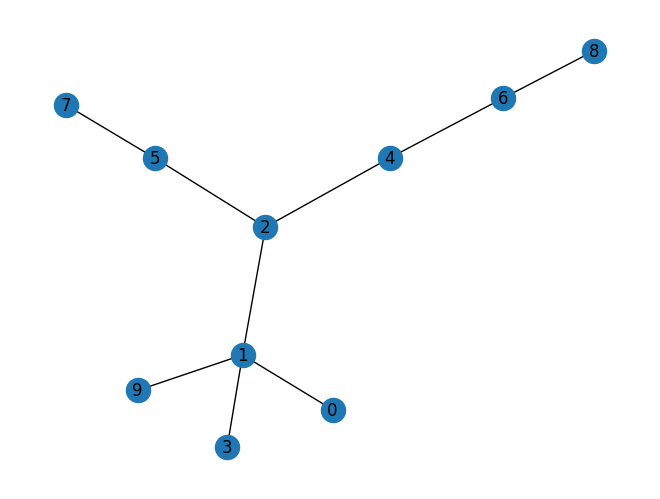

In [ ]:
# In[9]:

nx.draw(R, with_labels = True)

In [ ]:
# In[10]:

M

{frozenset({0, 1, 2}): 4,
 frozenset({0, 1, 2, 3, 4, 5}): 1,
 frozenset({0, 1, 2, 3, 4}): 2,
 frozenset({5}): 3,
 frozenset({3, 4}): 5,
 frozenset({1, 2}): 6,
 frozenset({3}): 7,
 frozenset({1}): 8,
 frozenset({3, 4, 5}): 9}